In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import random
import torch

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [ ]:
def display(data, pred = None, vert = None, title = 'Prediction'):
  data = np.array(data).reshape((len(data), 1))
  plt.figure(figsize=(12, 6))
  plt.plot(data, label='Some periodic function')
  if pred != None:
    plt.plot(pred, label=title)
  if vert != None:
    plt.axvline(x=vert, c='r', linestyle='--')
  plt.legend()
  plt.grid()
  plt.show()

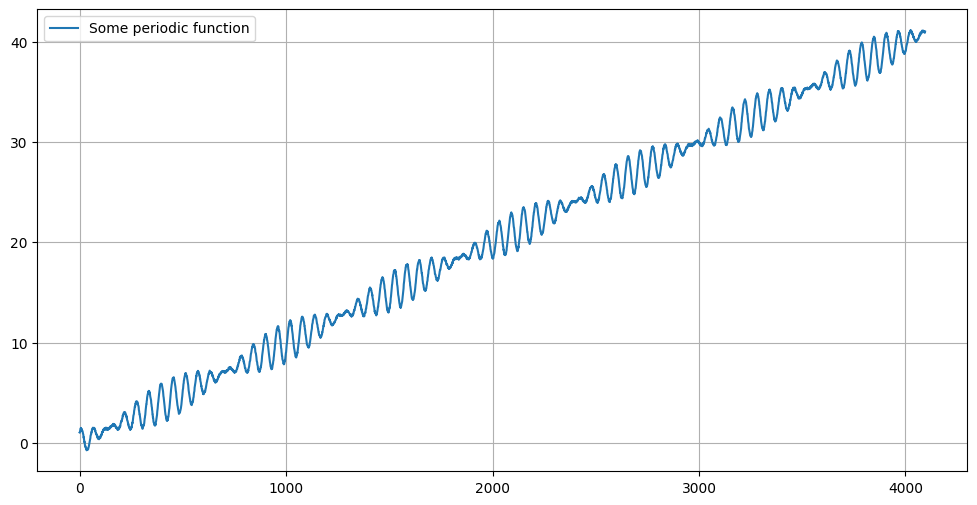

In [ ]:
training_data = []
for i in range(4096):
    training_data.append(math.sin(i / 10) +
                         math.cos((i) / 9) +
                         i / 100 +
                         (random.random() - 0.5) / 5)

display(training_data)

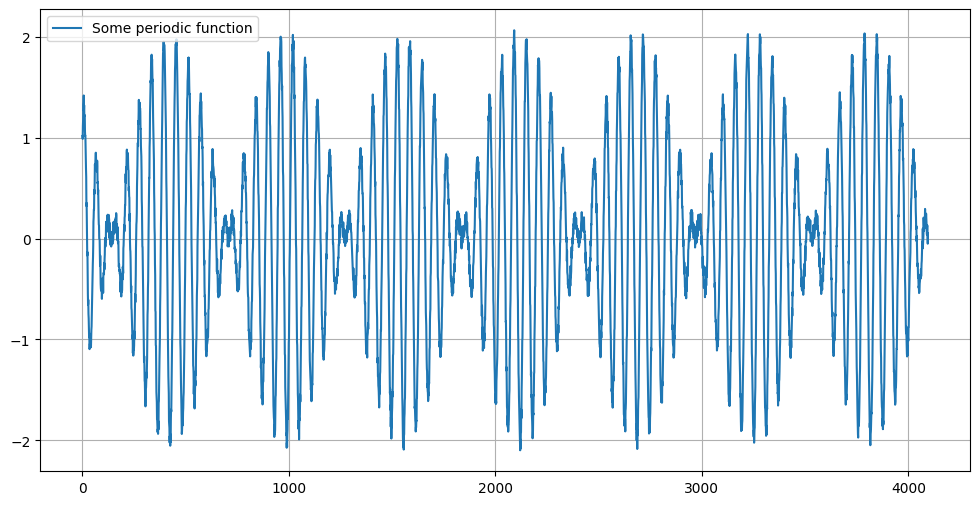

In [ ]:
from scipy.signal import detrend
stationary_data = detrend(training_data)
display(stationary_data)

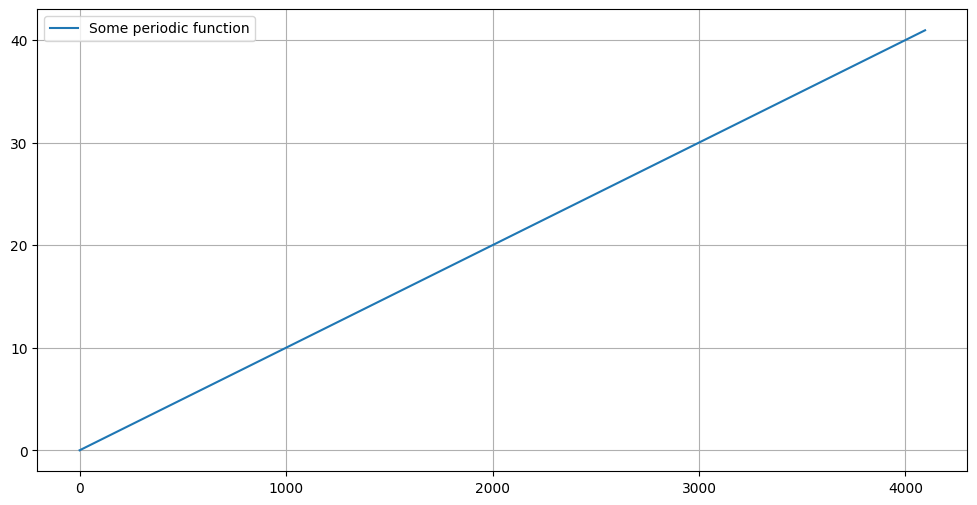

In [ ]:
trend = training_data - stationary_data
display(trend) #save trend

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(stationary_data.reshape(-1,1))
print(f"Var: {scaler.var_[0]:.2f} Mean {scaler.mean_[0]:.2f}")

Var: 0.98 Mean 0.00


In [ ]:
# Min - Max normalization
td_min = min(training_data)
td_max = max(training_data)
print('Initial statistics:')
print('Minimum value:', repr(td_min).rjust(5))
print('Maximum value:', repr(td_max).rjust(5))
a1 = [i - td_min for i in training_data]
c1 = td_max - td_min
#training_data = a1 / (td_max - td_min)
training_data = [i / c1 for i in a1]
print('\nResulting statistics:')
print('Minimum value:', repr(min(training_data)).rjust(5))
print('Maximum value:', repr(max(training_data)).rjust(5))

Initial statistics:
Minimum value: -0.7442023688338337
Maximum value: 41.130602994975106

Resulting statistics:
Minimum value:   0.0
Maximum value:   1.0


In [ ]:
# create data "ensemble"
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(training_data) - seq_length):
        _x = training_data[i:(i + seq_length)] # picking several sequential observations
        _y = training_data[i+seq_length] # picking the subsequent observation
        x.append(_x)
        y.append(_y)

    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))
    
# set length of the ensemble; accuracy of the predictions and 
# speed perfomance almost always depend on it size
seq_length = 32 # compare 2 and 32
x, y = sliding_windows(training_data, seq_length)
x = x[:, :, None]
y = y[:, None]
print("Example of the obtained data:\n")
print("Data corresponding to the first x:")
print(x[0])
print("Data corresponding to the first y:")
print(y[0])

Example of the obtained data:

Data corresponding to the first x:
tensor([[0.0423],
        [0.0419],
        [0.0452],
        [0.0468],
        [0.0507],
        [0.0515],
        [0.0533],
        [0.0499],
        [0.0515],
        [0.0493],
        [0.0495],
        [0.0499],
        [0.0463],
        [0.0455],
        [0.0457],
        [0.0431],
        [0.0392],
        [0.0385],
        [0.0369],
        [0.0303],
        [0.0312],
        [0.0279],
        [0.0233],
        [0.0195],
        [0.0206],
        [0.0149],
        [0.0112],
        [0.0089],
        [0.0102],
        [0.0071],
        [0.0063],
        [0.0045]])
Data corresponding to the first y:
tensor([0.0023])


In [ ]:
train_size = int(len(y) * 0.8)

x_train = x[:train_size]
y_train = y[:train_size]

x_test = x[train_size:]
y_test = y[train_size:]

print("Train data:")
print("x shape:", x_train.shape)
print("y shape:", y_train.shape)

print("\nTest data:")
print("x shape:", x_test.shape)
print("y shape:", y_test.shape)

Train data:
x shape: torch.Size([3251, 32, 1])
y shape: torch.Size([3251, 1])

Test data:
x shape: torch.Size([813, 32, 1])
y shape: torch.Size([813, 1])


In [ ]:
class AirTrafficPredictor(nn.Module):

    def __init__(self, input_size, hidden_size):
        # hidden_size == number of neurons 
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1) # Predict only one value

    def forward(self, x):
        #print("x: ",x.shape) # 108 x 8 x 1 : [batch_size, seq_len, input_size] 
        out, h = self.rnn(x) 
        #print("out: ", out.shape) # 108 x 8 x 4 : [batch_size, seq_len, hidden_size] Useless!
        #print("h : ", h.shape) # 1 x 108 x 4 [ num_layers, batch_size, hidden_size]
        y = self.fc(h)
        #print("y",y.shape) # 1 x 108 x 1
        return y, h

In [ ]:
def time_series_train(model, num_epochs=2000, learning_rate=0.01):
  
  criterion = torch.nn.MSELoss() # mean-squared error for regression
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Train the model
  for epoch in range(num_epochs):
      y_pred, h = model(x_train) # we don't use h there, but we can!
      optimizer.zero_grad()
      
      # obtain the loss
      loss = criterion(y_pred[0], y_train) # for shape compatibility
      loss.backward()
      
      optimizer.step()
      if epoch % 100 == 0:
          print(f"Epoch: {epoch},".ljust(15), "loss: %1.5f" % (loss.item()))

print("Simple RNN training process with MSE loss:")
input_size = 1
hidden_size = 2
rnn = AirTrafficPredictor(input_size, hidden_size)
time_series_train(rnn)

Simple RNN training process with MSE loss:
Epoch: 0,       loss: 0.16558
Epoch: 100,     loss: 0.00004
Epoch: 200,     loss: 0.00003
Epoch: 300,     loss: 0.00003
Epoch: 400,     loss: 0.00003
Epoch: 500,     loss: 0.00003
Epoch: 600,     loss: 0.00003
Epoch: 700,     loss: 0.00002
Epoch: 800,     loss: 0.00002
Epoch: 900,     loss: 0.00002
Epoch: 1000,    loss: 0.00002
Epoch: 1100,    loss: 0.00002
Epoch: 1200,    loss: 0.00002
Epoch: 1300,    loss: 0.00002
Epoch: 1400,    loss: 0.00002
Epoch: 1500,    loss: 0.00002
Epoch: 1600,    loss: 0.00002
Epoch: 1700,    loss: 0.00001
Epoch: 1800,    loss: 0.00001
Epoch: 1900,    loss: 0.00001


In [ ]:
train_predict, h = rnn(x)
train_predict[0].shape

torch.Size([4064, 1])

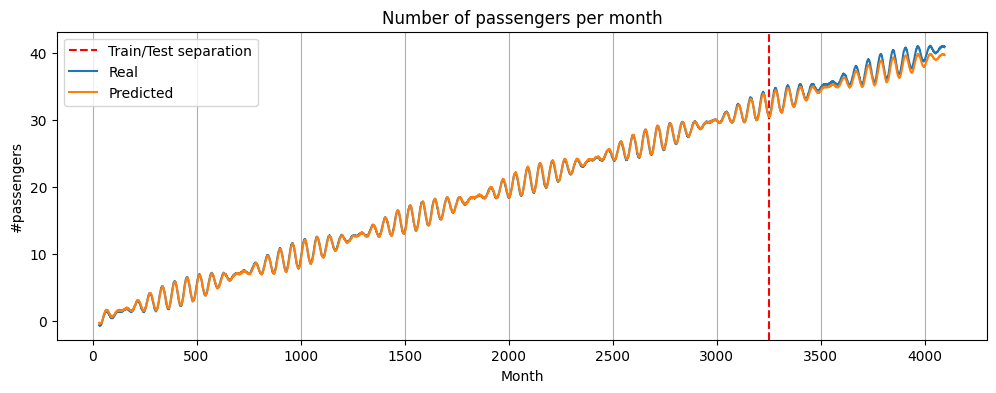

In [ ]:
def time_series_plot(train_predict):
  data_predict = train_predict.data
  y_data_plot = y.data

  # Denormalize
  data_predict = data_predict[0] * (td_max - td_min) + td_min
  y_data_plot = y_data_plot * (td_max - td_min) + td_min 

  # Plotting
  plt.figure(figsize=(12, 4))
  plt.axvline(x=train_size, c='r', linestyle='--')
  # shifting the curve as first y-value not correspond first value overall
  plt.plot(seq_length + np.arange(y_data_plot.shape[0]), y_data_plot)
  plt.plot(seq_length + np.arange(y_data_plot.shape[0]), data_predict)
  
  plt.title("Number of passengers per month")
  plt.ylabel("#passengers")
  plt.xlabel("Month")
  
  plt.legend(['Train/Test separation', 'Real', 'Predicted'])
  plt.grid(axis='x')
  plt.show()

rnn.eval()
train_predict, h = rnn(x)
time_series_plot(train_predict)

In [ ]:
class LSTMAirTrafficPredictor(nn.Module):

    def __init__(self, input_size, hidden_size):
        # hidden_size == number of neurons 
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1) # Predict only one value

    def forward(self, x):
        out, (h, c) = self.lstm(x) 
        y = self.fc(h)
        return y

lstm =  LSTMAirTrafficPredictor(input_size=1, hidden_size=2)
input = input = torch.randn((108, 1, 1)) 
out = lstm(input)

print("LSTM model we use consider first input dimension as a batch dimension, output dimension logic has not changed:")
print("Input shape:".ljust(15), input.shape)
print("Output shape:".ljust(15), out.shape)

LSTM model we use consider first input dimension as a batch dimension, output dimension logic has not changed:
Input shape:    torch.Size([108, 1, 1])
Output shape:   torch.Size([1, 108, 1])


In [ ]:
lstm.train()

print("LSTM training process with MSE loss:")

num_epochs = 2000
learning_rate = 0.01

criterion = torch.nn.MSELoss() # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

 # Train the model
for epoch in range(num_epochs):
    y_pred = lstm(x_train) 
    optimizer.zero_grad()
    #print(outputs.shape)
    loss = criterion(y_pred, y_train.unsqueeze(0))
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch: {epoch},".ljust(15), "loss: %1.5f" % (loss.item()))

LSTM training process with MSE loss:
Epoch: 0,       loss: 0.19320
Epoch: 100,     loss: 0.03320
Epoch: 200,     loss: 0.00007
Epoch: 300,     loss: 0.00007
Epoch: 400,     loss: 0.00006
Epoch: 500,     loss: 0.00005
Epoch: 600,     loss: 0.00005
Epoch: 700,     loss: 0.00004
Epoch: 800,     loss: 0.00004
Epoch: 900,     loss: 0.00003
Epoch: 1000,    loss: 0.00003
Epoch: 1100,    loss: 0.00002
Epoch: 1200,    loss: 0.00002
Epoch: 1300,    loss: 0.00002
Epoch: 1400,    loss: 0.00001
Epoch: 1500,    loss: 0.00001
Epoch: 1600,    loss: 0.00001
Epoch: 1700,    loss: 0.00001
Epoch: 1800,    loss: 0.00001
Epoch: 1900,    loss: 0.00001


In [ ]:
lstm.eval()
train_predict = lstm(x)

In [ ]:
train_predict.shape

torch.Size([1, 4064, 1])

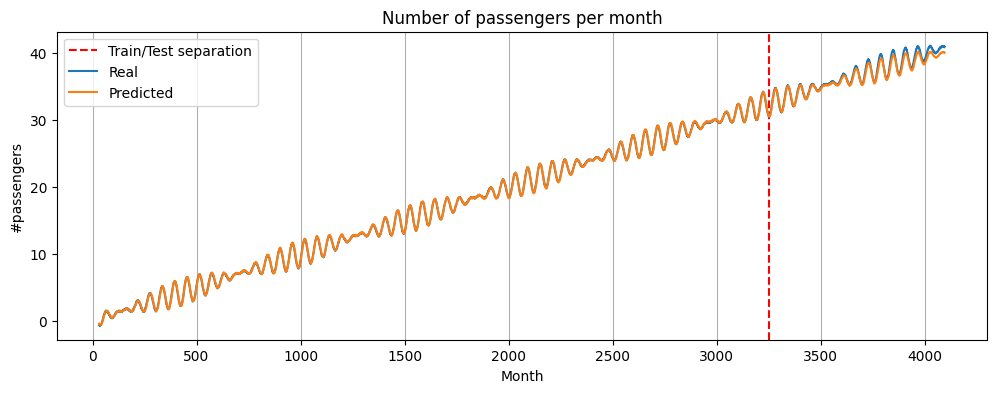

In [ ]:
#labels_to_display = [i for i in range(training_data.shape[0]) if i % 12 == 0]
time_series_plot(train_predict)

In [ ]:
class GRU(nn.Module):

    def __init__(self, input_size, hidden_size):
        # hidden_size == number of neurons 
        super().__init__()
        self.lstm = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1) # Predict only one value

    def forward(self, x):
        out, h = self.lstm(x) 
        y = self.fc(h)
        return y

lstm =  GRU(input_size=1, hidden_size=2)
input = input = torch.randn((108, 1, 1)) 
out = lstm(input)

print("LSTM model we use consider first input dimension as a batch dimension, output dimension logic has not changed:")
print("Input shape:".ljust(15), input.shape)
print("Output shape:".ljust(15), out.shape)

LSTM model we use consider first input dimension as a batch dimension, output dimension logic has not changed:
Input shape:    torch.Size([108, 1, 1])
Output shape:   torch.Size([1, 108, 1])


In [ ]:
lstm.train()

print("LSTM training process with MSE loss:")

num_epochs = 2000
learning_rate = 0.01

criterion = torch.nn.MSELoss() # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

 # Train the model
for epoch in range(num_epochs):
    y_pred = lstm(x_train) 
    optimizer.zero_grad()
    #print(outputs.shape)
    loss = criterion(y_pred, y_train.unsqueeze(0))
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch: {epoch},".ljust(15), "loss: %1.5f" % (loss.item()))

LSTM training process with MSE loss:
Epoch: 0,       loss: 0.46040
Epoch: 100,     loss: 0.01400
Epoch: 200,     loss: 0.00118
Epoch: 300,     loss: 0.00060
Epoch: 400,     loss: 0.00051
Epoch: 500,     loss: 0.00044
Epoch: 600,     loss: 0.00038
Epoch: 700,     loss: 0.00033
Epoch: 800,     loss: 0.00029
Epoch: 900,     loss: 0.00025
Epoch: 1000,    loss: 0.00022
Epoch: 1100,    loss: 0.00019
Epoch: 1200,    loss: 0.00017
Epoch: 1300,    loss: 0.00015
Epoch: 1400,    loss: 0.00013
Epoch: 1500,    loss: 0.00011
Epoch: 1600,    loss: 0.00009
Epoch: 1700,    loss: 0.00008
Epoch: 1800,    loss: 0.00006
Epoch: 1900,    loss: 0.00005


In [ ]:
lstm.eval()
train_predict = lstm(x)

In [ ]:
train_predict.shape

torch.Size([1, 4064, 1])

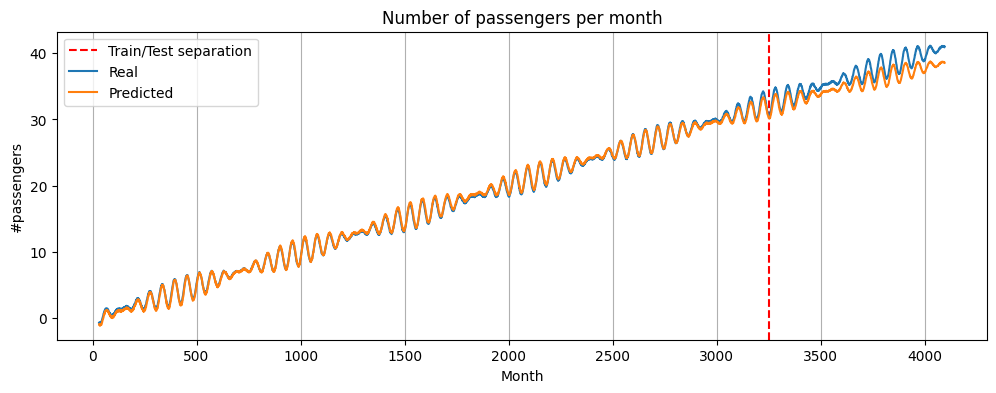

In [ ]:
time_series_plot(train_predict)